### 환경 초기화

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# 환경 초기화
env = gym.make('CartPole-v1', render_mode=None)

### 환경 관련 상수 정의

In [2]:
# 상태 변수별 버킷 수 (position, velocity, angle, angular velocity)
NUM_BUCKETS = (6, 3, 12, 6) # 각 차원별 버킷 수

# 행동 수 (왼쪽으로 밀기, 오른쪽으로 밀기)
NUM_ACTIONS = env.action_space.n # 2

# 상태 변수의 경계값 [min, max]
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high)) # [(-4.8, 4.8), (-3.4028235e+38, 3.4028235e+38), (-0.41887903, 0.41887903), (-3.4028235e+38, 3.4028235e+38)]
STATE_BOUNDS[0] = [-2.4, 2.4] # 위치 제한 
STATE_BOUNDS[1] = [-3.0, 3.0] # 속도 제한 
STATE_BOUNDS[2] = [-math.radians(12), math.radians(12)] # 각도 제한
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)] # 각속도 제한

# 학습 파라미터
INITIAL_LEARNING_RATE = 0.5 # alpha
MIN_LEARNING_RATE = 0.01   # 최소 학습률
DISCOUNT_FACTOR = 0.99 # gamma
NUM_EPISODES = 5000 # 총 학습 에피소드 수
MAX_T = 500 # 최대 타임스텝

# 탐험률(epsilon) 관련 파라미터
INITIAL_EXPLORE_RATE = 1.0 # 초기 탐험률
MIN_EXPLORE_RATE = 0.01   # 최소 탐험률
EXPLORATION_DECAY_RATE = (INITIAL_EXPLORE_RATE - MIN_EXPLORE_RATE) / (NUM_EPISODES * 0.8) # 80% 에피소드 동안 감소


# 해결 기준
SOLVED_T = 475 # 이 타임스텝 이상이면 성공으로 간주
STREAK_TO_END = 100 # 연속 성공 횟수 목표

### Q 테이블 초기화

In [3]:
# (pos_bucket, vel_bucket, ang_bucket, ang_vel_bucket, num_actions) 크기의 테이블
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,)) # (1, 1, 6, 3, 2)

### 유틸리티 함수

In [4]:
def state_to_bucket(state):
    """연속적인 상태를 이산적인 버킷 인덱스로 변환"""
    bucket_indice = [] # 각 차원의 버킷 인덱스를 저장할 리스트
    for i in range(len(state)):
        # 1. 상태 값이 미리 정의된 경계(STATE_BOUNDS) 밖에 있는지 확인
        if state[i] <= STATE_BOUNDS[i][0]: 
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]: 
            bucket_index = NUM_BUCKETS[i] - 1
        else: 
            # 2. 상태 값이 경계 내에 있는 경우, 어느 버킷에 속하는지 계산
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0] # 해당 차원의 전체 범위 크기
            # 버킷 너비 계산 (구간 크기 / 구간 수)
            bucket_width = bound_width / NUM_BUCKETS[i] if NUM_BUCKETS[i] > 0 else bound_width

            if bucket_width > 0 :
              # (현재 상태 값 - 최소 경계 값) / 버킷 너비 = 몇 번째 버킷인지 (0부터 시작)
              index_float = (state[i] - STATE_BOUNDS[i][0]) / bucket_width
              # math.floor를 사용하여 소수점 이하를 버리고 정수 인덱스를 얻음
              bucket_index = int(min(math.floor(index_float), NUM_BUCKETS[i] - 1))
            else: # 버킷 수가 0 또는 1인 이론적인 예외 케이스 처리
              bucket_index = 0

        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

def select_action(state, explore_rate):
    """epsilon-greedy 정책에 따라 행동 선택"""
    # 0과 1 사이의 무작위 실수를 생성하여 explore_rate와 비교
    if np.random.random() < explore_rate: 
        action = env.action_space.sample() # 탐험(Exploration): 무작위 행동 선택
    else:
        action = np.argmax(q_table[state]) # 활용(Exploitation): 현재 상태에서 Q-값이 가장 높은 행동 선택
    return action

def get_explore_rate(episode):
    """탐험률 계산"""
    return max(MIN_EXPLORE_RATE, min(INITIAL_EXPLORE_RATE, 1.0 - math.log10((episode + 1) / 25)))


def get_learning_rate(episode):
    """학습률 계산"""
    decay_episodes = NUM_EPISODES * 0.8
    rate = INITIAL_LEARNING_RATE - (INITIAL_LEARNING_RATE - MIN_LEARNING_RATE) * (episode / decay_episodes)
    return max(MIN_LEARNING_RATE, rate) if episode < decay_episodes else MIN_LEARNING_RATE

### 메인 학습 루프

In [5]:
print("Q-러닝 학습 시작...")
start_time = time.time() # 학습 시작 시간 기록

total_rewards = [] # 에피소드별 총 보상 저장
num_streaks = 0 # 연속 성공 횟수

for episode in range(NUM_EPISODES):
    # 1. 에피소드 시작: 환경 초기화 및 초기 상태 설정
    obv, info = env.reset()
    state_0 = state_to_bucket(obv) # 초기 관측값(연속적 상태)을 버킷 인덱스(이산적 상태)로 변환
    episode_reward = 0

    # 2. 현재 에피소드의 학습률 및 탐험률 계산 (동적 변경)
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

    # 에피소드 종료 플래그 초기화
    done = False # 환경이 종료 조건(넘어짐, 경계 벗어남)에 도달했는지 여부
    truncated = False # 환경이 최대 타임스텝(MAX_T)에 도달하여 강제 종료되었는지 여부
    t = 0 # 현재 에피소드 내 타임스텝 카운터

    # 3. 한 에피소드 진행 루프 (done 또는 truncated가 True가 될 때까지 반복)
    while not done and not truncated:
        # 3.1. 행동 선택 (Epsilon-Greedy 정책 사용)
        action = select_action(state_0, explore_rate)
        # 3.2. 선택한 행동을 환경에 적용하고 결과(다음 상태, 보상 등) 받기
        obv, reward, done, truncated, info = env.step(action)
        # 3.3. 다음 상태(obv)를 버킷 인덱스로 변환
        state = state_to_bucket(obv)
        # 3.4. Q-테이블 업데이트 (Q-러닝의 핵심)
        best_q = np.max(q_table[state])
        target = reward if done else reward + DISCOUNT_FACTOR * best_q # 목표 Q 값 계산
        q_table[state_0 + (action,)] += learning_rate * (target - q_table[state_0 + (action,)]) # Q 값 업데이트
        # 3.5. 상태 업데이트 및 보상/타임스텝 누적
        state_0 = state # 현재 상태 업데이트
        episode_reward += reward
        t += 1

    # 4. 에피소드 종료 후 처리
    total_rewards.append(episode_reward)

    # 성공 기준(SOLVED_T) 달성 여부 확인 및 연속 성공 횟수(num_streaks) 업데이트
    if t >= SOLVED_T:
        num_streaks += 1
    else:
        num_streaks = 0
    
    # 일정 에피소드(여기서는 100)마다 학습 진행 상황 출력
    if (episode + 1) % 100 == 0: 
        avg_reward = np.mean(total_rewards[-100:]) # 최근 100 에피소드 평균 보상
        print(f"Episode {episode + 1}/{NUM_EPISODES} | Timesteps: {t} | Avg Reward (last 100): {avg_reward:.2f} | LR: {learning_rate:.4f} | Exp Rate: {explore_rate:.4f} | Streaks: {num_streaks}")

    # 5. 학습 완료 조건 확인 (연속 성공 횟수 달성)
    if num_streaks >= STREAK_TO_END:
        print(f"\n환경 해결! ({STREAK_TO_END} 연속 성공 in {episode + 1} episodes)")
        break
    
# 학습 총 소요 시간 계산 및 출력
end_time = time.time()
print(f"총 학습 시간: {end_time - start_time:.2f} 초")

Q-러닝 학습 시작...


/home/sliver/.conda/envs/kjmin/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100/5000 | Timesteps: 16 | Avg Reward (last 100): 32.48 | LR: 0.4879 | Exp Rate: 0.3979 | Streaks: 0
Episode 200/5000 | Timesteps: 500 | Avg Reward (last 100): 126.88 | LR: 0.4756 | Exp Rate: 0.0969 | Streaks: 1
Episode 300/5000 | Timesteps: 500 | Avg Reward (last 100): 294.20 | LR: 0.4634 | Exp Rate: 0.0100 | Streaks: 1
Episode 400/5000 | Timesteps: 72 | Avg Reward (last 100): 238.43 | LR: 0.4511 | Exp Rate: 0.0100 | Streaks: 0
Episode 500/5000 | Timesteps: 182 | Avg Reward (last 100): 230.53 | LR: 0.4389 | Exp Rate: 0.0100 | Streaks: 0
Episode 600/5000 | Timesteps: 145 | Avg Reward (last 100): 98.60 | LR: 0.4266 | Exp Rate: 0.0100 | Streaks: 0
Episode 700/5000 | Timesteps: 142 | Avg Reward (last 100): 154.16 | LR: 0.4144 | Exp Rate: 0.0100 | Streaks: 0
Episode 800/5000 | Timesteps: 283 | Avg Reward (last 100): 199.20 | LR: 0.4021 | Exp Rate: 0.0100 | Streaks: 0
Episode 900/5000 | Timesteps: 119 | Avg Reward (last 100): 128.84 | LR: 0.3899 | Exp Rate: 0.0100 | Streaks: 0
Episo

### 결과 시각화

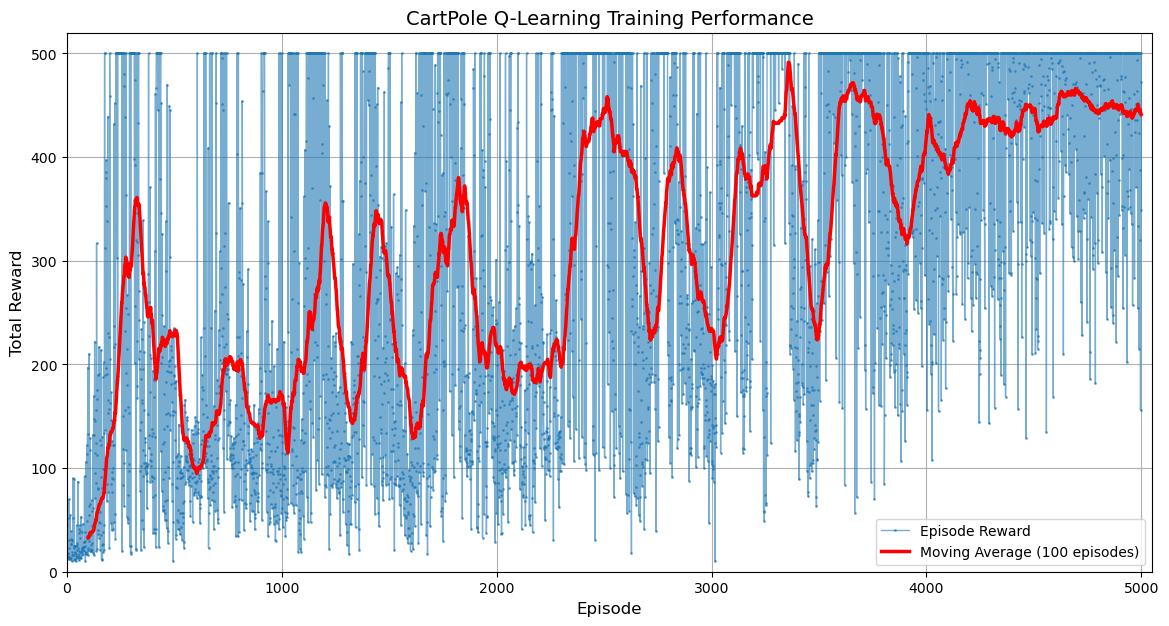

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(total_rewards, label='Episode Reward', alpha=0.6, linewidth=1.0, marker='.', markersize=2)
window_size = 100 # 이동 평균을 계산할 윈도우 크기 (최근 100개 에피소드 평균)
if len(total_rewards) >= window_size:
    moving_avg = np.convolve(total_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + window_size - 1, moving_avg, label=f'Moving Average ({window_size} episodes)', color='red', linewidth=2.5)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.title('CartPole Q-Learning Training Performance', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.ylim(0, MAX_T + 20)
plt.xlim(0, episode + 50)
plt.show()

### 테스트

In [7]:
print("\n학습된 정책 테스트 시작...")
env_render = gym.make('CartPole-v1', render_mode='human')
obv_render, info_render = env_render.reset()
state_render = state_to_bucket(obv_render)
episode_reward_test = 0
done_test = False
truncated_test = False
t_test = 0

while not done_test and not truncated_test:
    # 학습된 정책만 사용하기 위해 explore_rate=0 으로 설정
    action = select_action(state_render, 0)
    obv_render, reward_test, done_test, truncated_test, info_render = env_render.step(action)
    state_render = state_to_bucket(obv_render)
    episode_reward_test += reward_test
    env_render.render() # 화면에 렌더링
    time.sleep(0.02) # 시각적 확인을 위한 약간의 딜레이
    t_test += 1

print(f"테스트 에피소드 종료. 총 보상: {episode_reward_test}, 타임스텝: {t_test}")


학습된 정책 테스트 시작...


/home/sliver/.conda/envs/kjmin/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


테스트 에피소드 종료. 총 보상: 500.0, 타임스텝: 500


### 환경 종료

In [8]:
env_render.close()
env.close()